In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# При создании модели использовались материалы статьи https://habr.com/ru/post/579050/, 
# и документация https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
# При оценке метрик использовалась библиотека: 
# https://github.com/rafaelpadilla/Object-Detection-Metrics

In [2]:
import torch
import torchvision
import numpy as np
import pandas as pd
import os
import sys
import glob
import cv2
from tqdm import tqdm 
import time
import matplotlib.pyplot as plt
from PIL import Image
from json import loads
import shutil

from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from torch import nn

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from torchvision.ops.boxes import nms

In [3]:
# Библиотека для оценки метрик
! pip install object_detection_metrics

# устанавливаем библиотеки для оценки метрики
from podm.metrics import get_pascal_voc_metrics, MetricPerClass, get_bounding_boxes

In [4]:
! git clone https://github.com/rafaelpadilla/Object-Detection-Metrics.git

ROOT_DIR = '/content'
# To find local version of the library
sys.path.append(os.path.join(ROOT_DIR, 'Object-Detection-Metrics'))

import _init_paths
from utils import *
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes
from Evaluator import *

Cloning into 'Object-Detection-Metrics'...
remote: Enumerating objects: 554, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 554 (delta 28), reused 34 (delta 13), pack-reused 500
Receiving objects: 100% (554/554), 10.64 MiB | 26.83 MiB/s, done.
Resolving deltas: 100% (250/250), done.


In [5]:
# Задаем все пути к файлам и создаем папки для последующей работы с подсчетом метрик
# Исходные файлы
path_to_files = "/content/drive/MyDrive/Misha/All_data_YOLO"
#os.listdir(path_to_files)

path_to_images = os.path.join(path_to_files, 'images/')
path_to_labels = os.path.join(path_to_files, 'labels/')
path_to_resized_images = os.path.join(path_to_files, 'resized_images/')

# Создание папок для последующей работы с метриками
try:
    os.mkdir(os.path.join(path_to_files, 'evaluate/'))
except OSError as error:
    print('Папка evaluate существует')

try:
    os.mkdir(os.path.join(path_to_files, 'evaluate/', 'grnd_truths/'))
except OSError as error:
    print('Папка grnd_truths существует')

try:
    os.mkdir(os.path.join(path_to_files, 'evaluate/', 'detections/'))
except OSError as error:
    print('Папка detections существует')

Папка evaluate существует
Папка grnd_truths существует
Папка detections существует


In [6]:
# Сортировка названия изображений и файлов разметки
file_names = sorted(os.listdir(path_to_images))
labels_names = sorted(os.listdir(path_to_labels))
print(file_names)
print(len(file_names))
print(labels_names)
print(len(labels_names))

['00295ab9-54.jpg', '0139bd63-246.jpg', '014248e4-7.jpg', '02a90e41-257.jpg', '05210e0b-93.jpg', '0534d275-215.jpg', '059670bb-277.jpg', '06429140-145.jpg', '06afcc9a-234.jpg', '07550b32-299.jpg', '07bae1d1-122.jpg', '0867df4c-253.jpg', '08bce65b-83.jpg', '0958bb5e-63.jpg', '09957fe1-19.jpg', '0b350902-94.jpg', '0cddd1d0-20.jpg', '0ce03a8b-236.jpg', '0d16e2c3-190.jpg', '0dc15f8a-232.jpg', '0df612aa-34.jpg', '0e545368-126.jpg', '0e896c8a-175.jpg', '0f696bf6-10.jpg', '0fec9f8b-4.jpg', '0ffdf60d-65.jpg', '111f3126-7.jpg', '11425f6c-252.jpg', '1160806d-99.jpg', '11933abf-154.jpg', '119e9857-219.jpg', '1240dcd3-102.jpg', '133cd500-148.jpg', '1432e69c-245.jpg', '14ce23d5-33.jpg', '1569265e-32.jpg', '15764358-78.jpg', '16129960-177.jpg', '16215539-57.jpg', '16d291f9-49.jpg', '1704aead-53.jpg', '18370751-226.jpg', '18dc6175-113.jpg', '19949439-96.jpg', '199527d5-268.jpg', '19f6895e-98.jpg', '1a7649b8-224.jpg', '1abcbc6f-76.jpg', '1b3c43eb-109.jpg', '1b541220-282.jpg', '1ef2a50a-130.jpg', '1f20

In [22]:
# Функция для изменения размеров изображения
def scale_image(input_image_path,
                output_image_path,
                width=None,
                height=None
                ):
    original_image = Image.open(input_image_path)
    w, h = original_image.size
    #print('The original image size is {wide} wide x {height} '
    #      'high'.format(wide=w, height=h))
 
    if width and height:
        max_size = (width, height)
    elif width:
        max_size = (width, h)
    elif height:
        max_size = (w, height)
    else:
        # No width or height specified
        raise RuntimeError('Width or height required!')
 
    original_image.thumbnail(max_size, Image.ANTIALIAS)
    original_image.save(output_image_path)
 
    scaled_image = Image.open(output_image_path)
    width, height = scaled_image.size
    #print('The scaled image size is {wide} wide x {height} '
    #      'high'.format(wide=width, height=height))
    return width, height

In [23]:
# Уменьшение размеров изображений и соответствующие преобразование bounding box'es
def ch_size_img_wth_lbl(path_to_images, 
                        path_to_labels,
                        photo_pxl_weight=480
                        ):
    PATH = os.path.abspath(os.path.join(path_to_images, '..'))
    # Расположение фотографий после изменения их размеров (для сохранения исходных файлов)
    path_to_resized_images = os.path.join(PATH, 'resized_images/')
    if not os.path.exists(path_to_resized_images):
        os.mkdir(path_to_resized_images)
    total_label_coords = []
    total_classes_list = []
    total_images_list = []
    labels_names = sorted(os.listdir(path_to_labels))

    for label_item in tqdm(labels_names):
        if os.path.exists(path_to_images+label_item[:-3]+'jpg'):
            label_coords = []
            classes_list = []
            original_image = Image.open(path_to_images+label_item[:-3]+'jpg')
            width, height = scale_image(path_to_images+label_item[:-3]+'jpg', 
                                        path_to_resized_images+label_item[:-3]+'jpg',
                                        width=photo_pxl_weight)
            #width, height = original_image.size                    
            with open(path_to_labels+label_item, 'r') as f:
                data = f.read()
            for item in data.split('\n'):
                if len(item)!=0:
                    list_coords = [float(x) for x in item.split()[1:]]
                    x_min = int(width*list_coords[0] - width*list_coords[2]/2)
                    y_min = int(height*list_coords[1] - height*list_coords[3]/2)
                    x_max = int(width*list_coords[0] + width*list_coords[2]/2)
                    y_max = int(height*list_coords[1] + height*list_coords[3]/2)
                    if (x_min < x_max) and (y_min<y_max):
                        label_coords.append([x_min, y_min, x_max, y_max])
                        classes_list.append(1)
            total_label_coords.append(label_coords)
            total_classes_list.append(classes_list)
            total_images_list.append(label_item[:-3]+'jpg')
    return total_images_list, total_classes_list, total_label_coords

In [25]:
total_images_list, total_classes_list, total_label_coords = ch_size_img_wth_lbl(
    path_to_images, path_to_labels, 480)

100%|██████████| 400/400 [01:00<00:00,  6.61it/s]


In [29]:
# Создание датафрейма для последующего использования в обучении модели
list_tuples = list(zip(total_images_list, total_classes_list, total_label_coords)) 
d_frame = pd.DataFrame(list_tuples, columns=['filename', 'class', 'bbox'])
d_frame.to_csv(path_to_files+'d_frame.csv', index=False)

In [30]:
print(labels_names)

['00295ab9-54.txt', '0139bd63-246.txt', '014248e4-7.txt', '02a90e41-257.txt', '05210e0b-93.txt', '0534d275-215.txt', '059670bb-277.txt', '06429140-145.txt', '06afcc9a-234.txt', '07550b32-299.txt', '07bae1d1-122.txt', '0867df4c-253.txt', '08bce65b-83.txt', '0958bb5e-63.txt', '09957fe1-19.txt', '0b350902-94.txt', '0cddd1d0-20.txt', '0ce03a8b-236.txt', '0d16e2c3-190.txt', '0dc15f8a-232.txt', '0df612aa-34.txt', '0e545368-126.txt', '0e896c8a-175.txt', '0f696bf6-10.txt', '0fec9f8b-4.txt', '0ffdf60d-65.txt', '111f3126-7.txt', '11425f6c-252.txt', '1160806d-99.txt', '11933abf-154.txt', '119e9857-219.txt', '1240dcd3-102.txt', '133cd500-148.txt', '1432e69c-245.txt', '14ce23d5-33.txt', '1569265e-32.txt', '15764358-78.txt', '16129960-177.txt', '16215539-57.txt', '16d291f9-49.txt', '1704aead-53.txt', '18370751-226.txt', '18dc6175-113.txt', '19949439-96.txt', '199527d5-268.txt', '19f6895e-98.txt', '1a7649b8-224.txt', '1abcbc6f-76.txt', '1b3c43eb-109.txt', '1b541220-282.txt', '1ef2a50a-130.txt', '1f20

In [31]:
d_frame.head(5)

,filename,class,bbox
0,00295ab9-54.jpg,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[115, 14, 125, 22], [8, 18, 17, 25], [6, 55, ..."
1,0139bd63-246.jpg,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[18, 3, 23, 12], [30, 15, 35, 19], [25, 18, 3..."
2,014248e4-7.jpg,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[19, 48, 34, 60], [41, 29, 54, 43], [124, 11,..."
3,02a90e41-257.jpg,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[87, 13, 96, 20], [66, 31, 75, 42], [29, 18, ..."
4,05210e0b-93.jpg,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[147, 12, 156, 21], [143, 29, 151, 36], [128,..."


In [32]:
# Код для чтения готового датафрейма (чтобы не запускать его создание каждый раз) 
def create_df(path_to_csv):
    d_frame = pd.read_csv(path_to_csv)
    d_frame['class'] = d_frame['class'].apply(lambda x: np.array(loads(x)))
    d_frame['bbox'] = d_frame['bbox'].apply(lambda x: np.array(loads(x)))
    return d_frame

d_frame = create_df(path_to_files+'d_frame.csv')
d_frame.head()

,filename,class,bbox
0,00295ab9-54.jpg,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[115, 14, 125, 22], [8, 18, 17, 25], [6, 55, ..."
1,0139bd63-246.jpg,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[18, 3, 23, 12], [30, 15, 35, 19], [25, 18, 3..."
2,014248e4-7.jpg,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[19, 48, 34, 60], [41, 29, 54, 43], [124, 11,..."
3,02a90e41-257.jpg,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[87, 13, 96, 20], [66, 31, 75, 42], [29, 18, ..."
4,05210e0b-93.jpg,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[147, 12, 156, 21], [143, 29, 151, 36], [128,..."


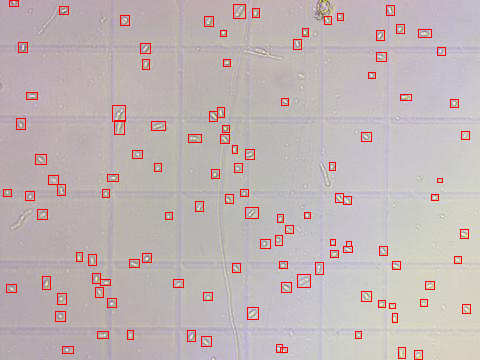

In [33]:
# Функция для просмотра размеченных изображений по индексу датафрейма
def draw_img_with_box(df_index, 
                      data_frame, 
                      path_to_images=path_to_resized_images):
                      #path_to_images=path_to_images):
    path_to_img = os.path.join(path_to_images, data_frame.loc[df_index, 'filename'])
    img = cv2.imread(path_to_img)
    #width, height = img.size
    width = int(img.shape[1])
    height = int(img.shape[0])
    boxes =  data_frame.loc[df_index, 'bbox']
    for box in boxes:
        cv2.rectangle(img, 
            (int(box[0]), int(box[1])), 
            (int(box[2]), int(box[3])), 
            (0, 0, 255), 0)
    cv2_imshow(img)
    
draw_img_with_box(50, d_frame)

In [34]:
# Создание экземляра класса выдчи изображения в формате torch.tensor 
# и словаря target (координаты рамки и класс) по индексу изображения из датафрема 
class MyDataset(Dataset):
  
    def __init__(self, dataframe, img_path):
        
        self.df = dataframe
        self.img_path = img_path

    def __len__(self):
        return self.df.shape[0]
  
    def __getitem__(self, index):
        img_name = self.df.loc[index,'filename']
        boxes = torch.Tensor(self.df.loc[index, 'bbox']).to(torch.float)
        labels = torch.Tensor(self.df.loc[index, 'class']).to(torch.int64)
        #area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 0])
        #iscrowd = torch.zeros(labels.shape[0], dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        img = cv2.imread(os.path.join(self.img_path, img_name))/255.
        img = torch.from_numpy(img).permute(2, 0, 1).to(torch.float)
        return img, target

In [35]:
# Функция для создания модели
def create_model(num_classes, pretrained=False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [36]:
# Вспомогательная функция применяется к бачам при итерации по torch.utils.data.DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

In [37]:
# Деление тренировочных данных на трейн и тест
rnd_seed = 123
from sklearn.model_selection import train_test_split 
df_train, df_val = train_test_split(d_frame, test_size=0.2, random_state=rnd_seed)
df_train = df_train.reset_index().drop('index', axis=1)
df_val = df_val.reset_index().drop('index', axis=1)
print(f'Количество строк в тренировочной выборке: {len(df_train)}')
print(f'Количество строк в тестовой выборке: {len(df_val)}')

Количество строк в тренировочной выборке: 320
Количество строк в тестовой выборке: 80


In [38]:
# Определяем на котором будет обучаться модель, создаем модель, определяем optimizer и 
# настраиваем уменьшение скорости обучения
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_classes=2, pretrained=False).to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

train_dataset = MyDataset(df_train, '/content/drive/MyDrive/Misha/All_data_YOLO/resized_images')
val_dataset = MyDataset(df_val, '/content/drive/MyDrive/Misha/All_data_YOLO/resized_images')

# Определяются загрузчики для тренировки модели и предсказания результатов
train_data_loader = DataLoader(
    train_dataset,
    batch_size=3,
    shuffle=True,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=3,
    shuffle=False,
    collate_fn=collate_fn
)

In [39]:
# Функции перевода данных внутри батча на устройство, на котором проводятся расчеты
def train(train_dataloader): 
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tИтерация #{i} loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [ ]:
# Тренировка модели
train_losses = []
val_losses = []
try:
    for epoch in range(20):
        start = time.time()
        train_loss = train(train_data_loader)
        val_loss = val(val_data_loader)
        scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
except KeyboardInterrupt:
    print('Прервано пользователем')

# Сохраняем веса модели
torch.save(model.state_dict(), path_to_files+'fasterrcnn_resnet50_fpn.pth')

In [ ]:
# Отображение истории обучения модели
fig, ax  = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()

In [ ]:
# Создание модели и загрузка весов ранее сохраненной модели (после обучения):
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = create_model(2).to(device)
if torch.cuda.is_available():
    model.load_state_dict(torch.load(os.path.join(path_to_files,'fasterrcnn_resnet50_fpn.pth')))
else: 
    model.load_state_dict(torch.load(os.path.join(path_to_files,'fasterrcnn_resnet50_fpn.pth'), 
                                     map_location=torch.device('cpu')))

In [ ]:
# Функция для создания вспомогательных файлов по предсказанным и размеченным данных 
# для использования импортированной библиотеки по оценке метрик
def write_boxes_for_metrics(df_index, is_predicted, box_0, box_1, box_2, box_3, confidence=None):
    if is_predicted:
        filename = os.path.join(
            path_to_files, 'evaluate/', 'detections/', df_val.loc[df_index, 'filename'])[:-3] + 'txt'
        with open(filename, "a") as file:
            file.write('micro_orgs' + ' ' + str(confidence) + ' ' + str(box_0) + ' '\
                       + str(box_1) + ' ' + str(box_2) + ' ' + str(box_3) + '\n')
    else:
        filename = os.path.join(
            path_to_files, 'evaluate/',  'grnd_truths/', df_val.loc[df_index, 'filename'])[:-3] + 'txt'
        with open(filename, "a") as file:
            file.write('micro_orgs' + ' ' + str(box_0) + ' ' + str(box_1) + ' ' + str(box_2) + ' '\
                       + str(box_3) + '\n')        

In [ ]:
def draw_predict(df_index, iou_threshold=0.1, threshold=0.5, draw=True):
    
    """
    Функция для оценки качества работы модели. Функция создает в отдельных папках файлы с 
    координатами размеченных и предсказанных bounding boxes для последующего расчета метрик по 
    индексу данных, представленных в датафрейме.
    Применен алгоритм non-maximum suppression, который реализован в библиотеке torchvision.
    Он объединяет похожие рамки на основе их взаимного пересечения, кот. были предсказаны моделью. 
    Дополнительно выводит на один рисунок изображение, размеченные и предсказанные 
    bounding boxes для визуального анализа результатов работы модели.

    """

    model.eval()
    img = cv2.imread(os.path.join(path_to_resized_images, df_val.loc[df_index, 'filename']))
    img_ = img / 255.
    img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device)
    predict = model(img_)
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()
    
    for file in glob.glob(os.path.join(path_to_files, 'evaluate/', 'detections/','*')):
        os.remove(file)
    
    for i, box in enumerate(predict[0]['boxes'][ind]):
        if predict[0]['scores'][i] > threshold:
            cv2.rectangle(img, 
                    (int(box[0]), int(box[1])), 
                    (int(box[2]), int(box[3])), 
                    (255, 0, 0), 0)
            #print(predict[0]['scores'][i].item())
            write_boxes_for_metrics(df_index, True, 
                                    int(box[0]), int(box[1]), int(box[2]), int(box[3]), 
                                    confidence = predict[0]['scores'][i].item())
            
    for file in glob.glob(os.path.join(path_to_files, 'evaluate/', 'grnd_truths/','*')):
        os.remove(file)

    boxes =  df_val.loc[df_index, 'bbox']
    
    for box in boxes:
        cv2.rectangle(img, 
            (int(box[0]), int(box[1])), 
            (int(box[2]), int(box[3])), 
            (0, 0, 255), 0)
        write_boxes_for_metrics(df_index, False, 
                                int(box[0]), int(box[1]), int(box[2]), int(box[3]))
    if draw:
        cv2_imshow(img)

In [ ]:
# Функция для преобразования txt файлов с координатами bounding boxes (ground truth and detections)
# для оценки метрики PascalVOC см:
# https://github.com/rafaelpadilla/Object-Detection-Metrics/tree/master/samples/sample_2

def getBoundingBoxes():
    """Read txt files containing bounding boxes (ground truth and detections)."""
    allBoundingBoxes = BoundingBoxes()
    # Read ground truths
    currentPath = os.path.dirname(os.path.join(path_to_files, 'evaluate/'))
    folderGT = os.path.join(currentPath,'grnd_truths')
    os.chdir(folderGT)
    files = glob.glob("*.txt")
    files.sort()
    # Class representing bounding boxes (ground truths and detections)
    allBoundingBoxes = BoundingBoxes()
    # Read GT detections from txt file
    # Each line of the files in the groundtruths folder represents a ground truth bounding box 
    # (bounding boxes that a detector should detect)
    # Each value of each line is  "class_id, x, y, width, height" respectively
    # Class_id represents the class of the bounding box
    # x, y represents the most top-left coordinates of the bounding box
    # x2, y2 represents the most bottom-right coordinates of the bounding box
    for f in files:
        nameOfImage = f.replace(".txt","")
        fh1 = open(f, "r")
        for line in fh1:
            line = line.replace("\n","")
            if line.replace(' ','') == '':
                continue
            splitLine = line.split(" ")
            idClass = splitLine[0] #class
            x = float(splitLine[1]) #confidence
            y = float(splitLine[2])
            w = float(splitLine[3])
            h = float(splitLine[4])
            bb = BoundingBox(nameOfImage,idClass,x,y,w,h,CoordinatesType.Absolute, None,
                             BBType.GroundTruth, format=BBFormat.XYX2Y2)
            allBoundingBoxes.addBoundingBox(bb)
        fh1.close()
    # Read detections
    folderDet = os.path.join(currentPath,'detections')
    os.chdir(folderDet)
    files = glob.glob("*.txt")
    files.sort()
    # Read detections from txt file
    # Each line of the files in the detections folder represents a detected bounding box.
    # Each value of each line is  "class_id, confidence, x, y, width, height" respectively
    # Class_id represents the class of the detected bounding box
    # Confidence represents the confidence (from 0 to 1) that this detection belongs to the class_id.
    # x, y represents the most top-left coordinates of the bounding box
    # x2, y2 represents the most bottom-right coordinates of the bounding box
    for f in files:
        # nameOfImage = f.replace("_det.txt","")
        nameOfImage = f.replace(".txt","")
        # Read detections from txt file
        fh1 = open(f, "r")
        for line in fh1:
            line = line.replace("\n","")
            if line.replace(' ','') == '':
                continue            
            splitLine = line.split(" ")
            idClass = splitLine[0] #class
            confidence = float(splitLine[1]) #confidence
            x = float(splitLine[2])
            y = float(splitLine[3])
            w = float(splitLine[4])
            h = float(splitLine[5])
            bb = BoundingBox(nameOfImage, idClass,x,y,w,h,CoordinatesType.Absolute, None, 
                             BBType.Detected, confidence, format=BBFormat.XYX2Y2)
            allBoundingBoxes.addBoundingBox(bb)
        fh1.close()
    return allBoundingBoxes

In [ ]:
def save_val_predicts(val_ind, df_val=df_val, iou_thresh = 0.1, thresh = 0.5, 
                      path_to_save = path_to_files):
    
    draw_predict(val_ind, iou_threshold=iou_thresh, threshold=thresh, draw=False)
    
    boundingboxes = getBoundingBoxes()
    # Create an evaluator object in order to obtain the metrics
    evaluator = Evaluator()
    metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=0.5)
    #print("Average precision values per class:\n")
    # Loop through classes to obtain their metrics
    for mc in metricsPerClass:
        # Get metric values per each class
        c = mc['class']
        precision = mc['precision']
        recall = mc['recall']
        average_precision = mc['AP']
        ipre = mc['interpolated precision']
        irec = mc['interpolated recall']
        # Print AP per class
        #print('%s: %f' % (c, average_precision))
        list_to_save = [df_val.filename[val_ind], ' ', 
                       f'iou_threshold={iou_thresh}', ' ', 
                       f'threshold={thresh}', ' ',  
                       f'class={c}', ' ', 
                       f'avrg_prec={average_precision}', '\n']
        with open(os.path.join(path_to_save, 'resnet_50_bb_metrics.txt'), "a") as file:
            for item in list_to_save:
                file.write(item)

In [ ]:
for ind in tqdm(df_val.index):
    save_val_predicts(ind)

100%|██████████| 80/80 [28:01<00:00, 21.02s/it]


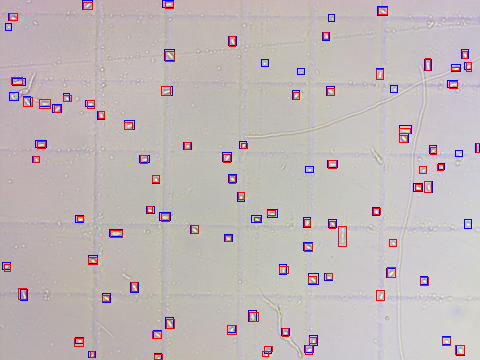

Average precision values per class:

micro_orgs: 0.913047


In [ ]:
draw_predict(50, 0.1)

boundingboxes = getBoundingBoxes()

# Create an evaluator object in order to obtain the metrics
evaluator = Evaluator()

metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=0.5)
print("Average precision values per class:\n")
# Loop through classes to obtain their metrics
for mc in metricsPerClass:
    # Get metric values per each class
    c = mc['class']
    precision = mc['precision']
    recall = mc['recall']
    average_precision = mc['AP']
    ipre = mc['interpolated precision']
    irec = mc['interpolated recall']
    # Print AP per class
    print('%s: %f' % (c, average_precision))

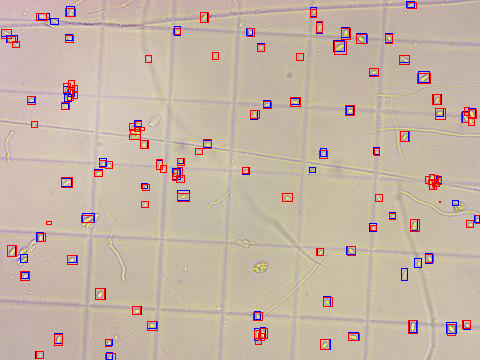

Average precision values per class:

micro_orgs: 0.667269


In [ ]:
draw_predict(40, 0.1)

boundingboxes = getBoundingBoxes()

# Create an evaluator object in order to obtain the metrics
evaluator = Evaluator()

metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=0.5)
print("Average precision values per class:\n")
# Loop through classes to obtain their metrics
for mc in metricsPerClass:
    # Get metric values per each class
    c = mc['class']
    precision = mc['precision']
    recall = mc['recall']
    average_precision = mc['AP']
    ipre = mc['interpolated precision']
    irec = mc['interpolated recall']
    # Print AP per class
    print('%s: %f' % (c, average_precision))

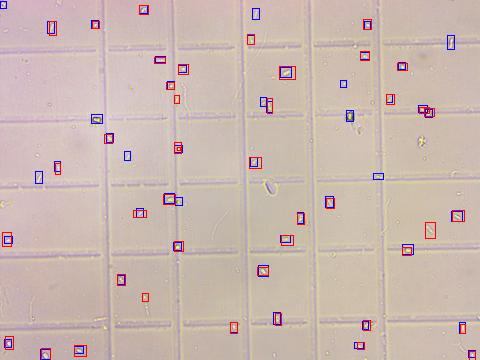

Average precision values per class:

micro_orgs: 0.724304


In [ ]:
draw_predict(79, 0.1)

boundingboxes = getBoundingBoxes()

# Create an evaluator object in order to obtain the metrics
evaluator = Evaluator()

metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=0.5)
print("Average precision values per class:\n")
# Loop through classes to obtain their metrics
for mc in metricsPerClass:
    # Get metric values per each class
    c = mc['class']
    precision = mc['precision']
    recall = mc['recall']
    average_precision = mc['AP']
    ipre = mc['interpolated precision']
    irec = mc['interpolated recall']
    # Print AP per class
    print('%s: %f' % (c, average_precision))

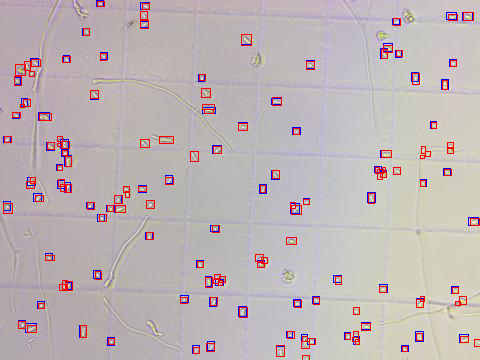

Average precision values per class:

micro_orgs: 0.664995


In [ ]:
draw_predict(78, 0.1)

boundingboxes = getBoundingBoxes()

# Create an evaluator object in order to obtain the metrics
evaluator = Evaluator()

metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=0.5)
print("Average precision values per class:\n")
# Loop through classes to obtain their metrics
for mc in metricsPerClass:
    # Get metric values per each class
    c = mc['class']
    precision = mc['precision']
    recall = mc['recall']
    average_precision = mc['AP']
    ipre = mc['interpolated precision']
    irec = mc['interpolated recall']
    # Print AP per class
    print('%s: %f' % (c, average_precision))

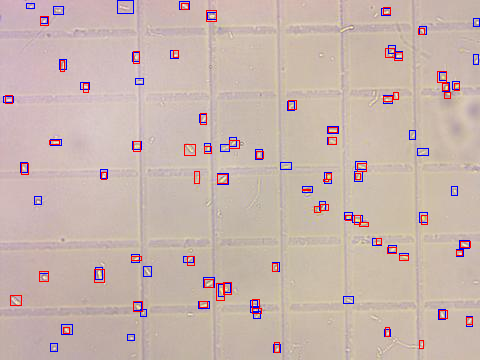

Average precision values per class:

micro_orgs: 0.490295


In [ ]:
draw_predict(77, 0.1)

boundingboxes = getBoundingBoxes()

# Create an evaluator object in order to obtain the metrics
evaluator = Evaluator()

metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=0.5)
print("Average precision values per class:\n")
# Loop through classes to obtain their metrics
for mc in metricsPerClass:
    # Get metric values per each class
    c = mc['class']
    precision = mc['precision']
    recall = mc['recall']
    average_precision = mc['AP']
    ipre = mc['interpolated precision']
    irec = mc['interpolated recall']
    # Print AP per class
    print('%s: %f' % (c, average_precision))

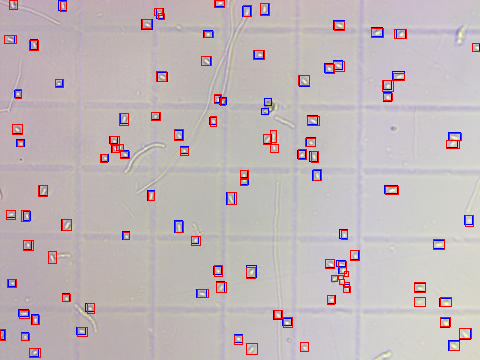

Average precision values per class:

micro_orgs: 0.872440


In [ ]:
draw_predict(75, 0.1)

boundingboxes = getBoundingBoxes()

# Create an evaluator object in order to obtain the metrics
evaluator = Evaluator()

metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=0.5)
print("Average precision values per class:\n")
# Loop through classes to obtain their metrics
for mc in metricsPerClass:
    # Get metric values per each class
    c = mc['class']
    precision = mc['precision']
    recall = mc['recall']
    average_precision = mc['AP']
    ipre = mc['interpolated precision']
    irec = mc['interpolated recall']
    # Print AP per class
    print('%s: %f' % (c, average_precision))

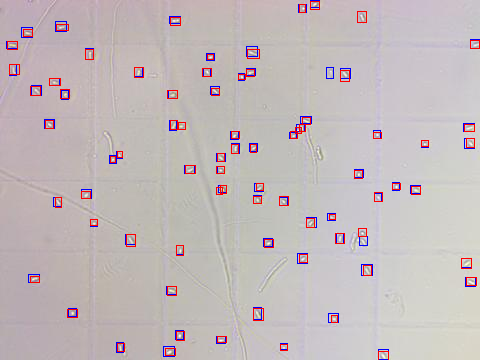

Average precision values per class:

micro_orgs: 0.971699


In [ ]:
draw_predict(5, 0.1)

boundingboxes = getBoundingBoxes()

# Create an evaluator object in order to obtain the metrics
evaluator = Evaluator()

metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=0.5)
print("Average precision values per class:\n")
# Loop through classes to obtain their metrics
for mc in metricsPerClass:
    # Get metric values per each class
    c = mc['class']
    precision = mc['precision']
    recall = mc['recall']
    average_precision = mc['AP']
    ipre = mc['interpolated precision']
    irec = mc['interpolated recall']
    # Print AP per class
    print('%s: %f' % (c, average_precision))

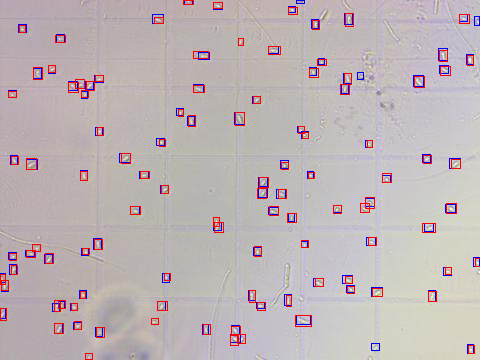

Average precision values per class:

micro_orgs: 0.905398


In [ ]:
draw_predict(25, 0.1)

boundingboxes = getBoundingBoxes()

# Create an evaluator object in order to obtain the metrics
evaluator = Evaluator()

metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=0.5)
print("Average precision values per class:\n")
# Loop through classes to obtain their metrics
for mc in metricsPerClass:
    # Get metric values per each class
    c = mc['class']
    precision = mc['precision']
    recall = mc['recall']
    average_precision = mc['AP']
    ipre = mc['interpolated precision']
    irec = mc['interpolated recall']
    # Print AP per class
    print('%s: %f' % (c, average_precision))

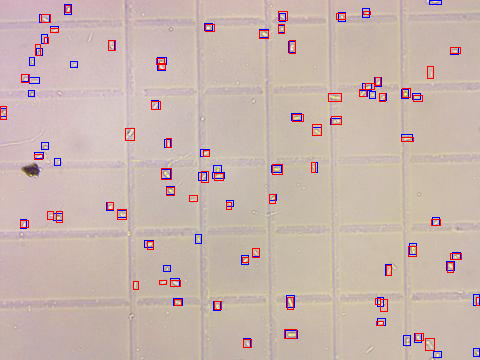

Average precision values per class:

micro_orgs: 0.641896


In [ ]:
draw_predict(33, 0.1)

boundingboxes = getBoundingBoxes()

# Create an evaluator object in order to obtain the metrics
evaluator = Evaluator()

metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=0.5)
print("Average precision values per class:\n")
# Loop through classes to obtain their metrics
for mc in metricsPerClass:
    # Get metric values per each class
    c = mc['class']
    precision = mc['precision']
    recall = mc['recall']
    average_precision = mc['AP']
    ipre = mc['interpolated precision']
    irec = mc['interpolated recall']
    # Print AP per class
    print('%s: %f' % (c, average_precision))

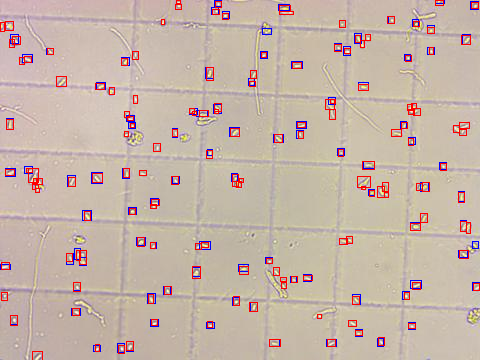

Average precision values per class:

micro_orgs: 0.568824


In [ ]:
draw_predict(13, 0.1)

boundingboxes = getBoundingBoxes()

# Create an evaluator object in order to obtain the metrics
evaluator = Evaluator()

metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=0.5)
print("Average precision values per class:\n")
# Loop through classes to obtain their metrics
for mc in metricsPerClass:
    # Get metric values per each class
    c = mc['class']
    precision = mc['precision']
    recall = mc['recall']
    average_precision = mc['AP']
    ipre = mc['interpolated precision']
    irec = mc['interpolated recall']
    # Print AP per class
    print('%s: %f' % (c, average_precision))

In [ ]:
# Проверка, что данные при валидации не попали в тренировочные данные (df_train)
[item for item in df_val.iloc[[50, 40, 79, 78, 77, 75, 5, 25, 33, 13]].filename.values \
    if item[0] in df_train.filename.values]

[]

## Архив

In [ ]:
total_label_coords = []
total_classes_list = []
for label_item in labels_names:
    label_coords = []
    classes_list = []
    width, height = scale_image(path_to_images+label_item[:-3]+'jpg', 
                                path_to_resized_images+label_item[:-3]+'jpg',
                                width=480)
    with open(path_to_labels+label_item, 'r') as f:
        data = f.read()
    for item in data.split('\n'):
        if len(item)!=0:
            list_coords = [float(x) for x in item.split()[1:]]
            x_min = int(width*list_coords[0] - width*list_coords[2]/2)
            y_min = int(height*list_coords[1] - height*list_coords[3]/2)
            x_max = int(width*list_coords[0] + width*list_coords[2]/2)
            y_max = int(height*list_coords[1] + height*list_coords[3]/2)
            if (y_min==y_max) or (x_min == x_max):
                print(item, label_item)
            label_coords.append([x_min, y_min, x_max, y_max])
            classes_list.append(1)
    total_label_coords.append(label_coords)
    total_classes_list.append(classes_list)
print(len(total_label_coords))